In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%pylab inline
import statsmodels.formula.api as smf
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import preprocessing
import urllib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import geopandas as gpd
import pyogrio
import matplotlib.colors as colors
import matplotlib.cm as cm

# To ignore some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Data Loading:

In [2]:
#station list
Stations = pd.read_csv( 'https://raw.githubusercontent.com/CUSP2021ADS/Data/main/NYCSubwayNodes.csv' , index_col=None, header=0 )
Stations.head()

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R


In [18]:
import pandas as pd

# Assuming you have a DataFrame named 'df' which contains a column 'name'
time_square_row = Stations.loc[Stations['name'] == "Times Sq - 42 St"]

# Display the row
print(time_square_row)


                 name   id boro        lat       long    lines
61   Times Sq - 42 St  902    M  40.755983 -73.986229        S
261  Times Sq - 42 St  127    M  40.755290 -73.987495    1 2 3
407  Times Sq - 42 St  R16    M  40.754672 -73.986754  N Q R W
465  Times Sq - 42 St  725    M  40.755477 -73.987691        7


In [3]:
#connection list
Links = pd.read_csv( 'https://raw.githubusercontent.com/CUSP2021ADS/Data/main/NYCSubwayEdges.csv' , index_col=None, header=0 )
Links.head()

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24


In [4]:
# NYC shape file w/ population by zipcode:
zippop = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/pri4-ifjk?date=20231207&accessType=DOWNLOAD&method=export&format=Shapefile')

In [5]:
zippop

,modzcta,label,zcta,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072.0,"POLYGON ((-73.98774 40.74407, -73.98819 40.743..."
1,10002,10002,10002,74993.0,"POLYGON ((-73.99750 40.71407, -73.99709 40.714..."
2,10003,10003,10003,54682.0,"POLYGON ((-73.98864 40.72293, -73.98876 40.722..."
3,10026,10026,10026,39363.0,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ..."
4,10004,10004,10004,3028.0,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ..."
...,...,...,...,...,...
173,11434,11434,"11430, 11434",65989.0,"POLYGON ((-73.75461 40.64720, -73.75380 40.646..."
174,11435,11435,11435,59296.0,"POLYGON ((-73.80577 40.68293, -73.80606 40.683..."
175,11694,11694,11694,21354.0,"POLYGON ((-73.86496 40.56663, -73.86558 40.567..."
176,11697,11697,11697,3540.0,"POLYGON ((-73.86289 40.57606, -73.86281 40.575..."


### Processing:

In [6]:
#create a dictionary of subway stations by name and location
StPos={Stations.id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.id[c]:Stations.name[c] for c in Stations.index}

In [7]:
#creare a directed graph subway network
NYCSubway=nx.DiGraph()
for i in Links.index:
    NYCSubway.add_edge(Links.origin[i],Links.dest[i])

### Original Graph that shows the stations and connections without any weighting:

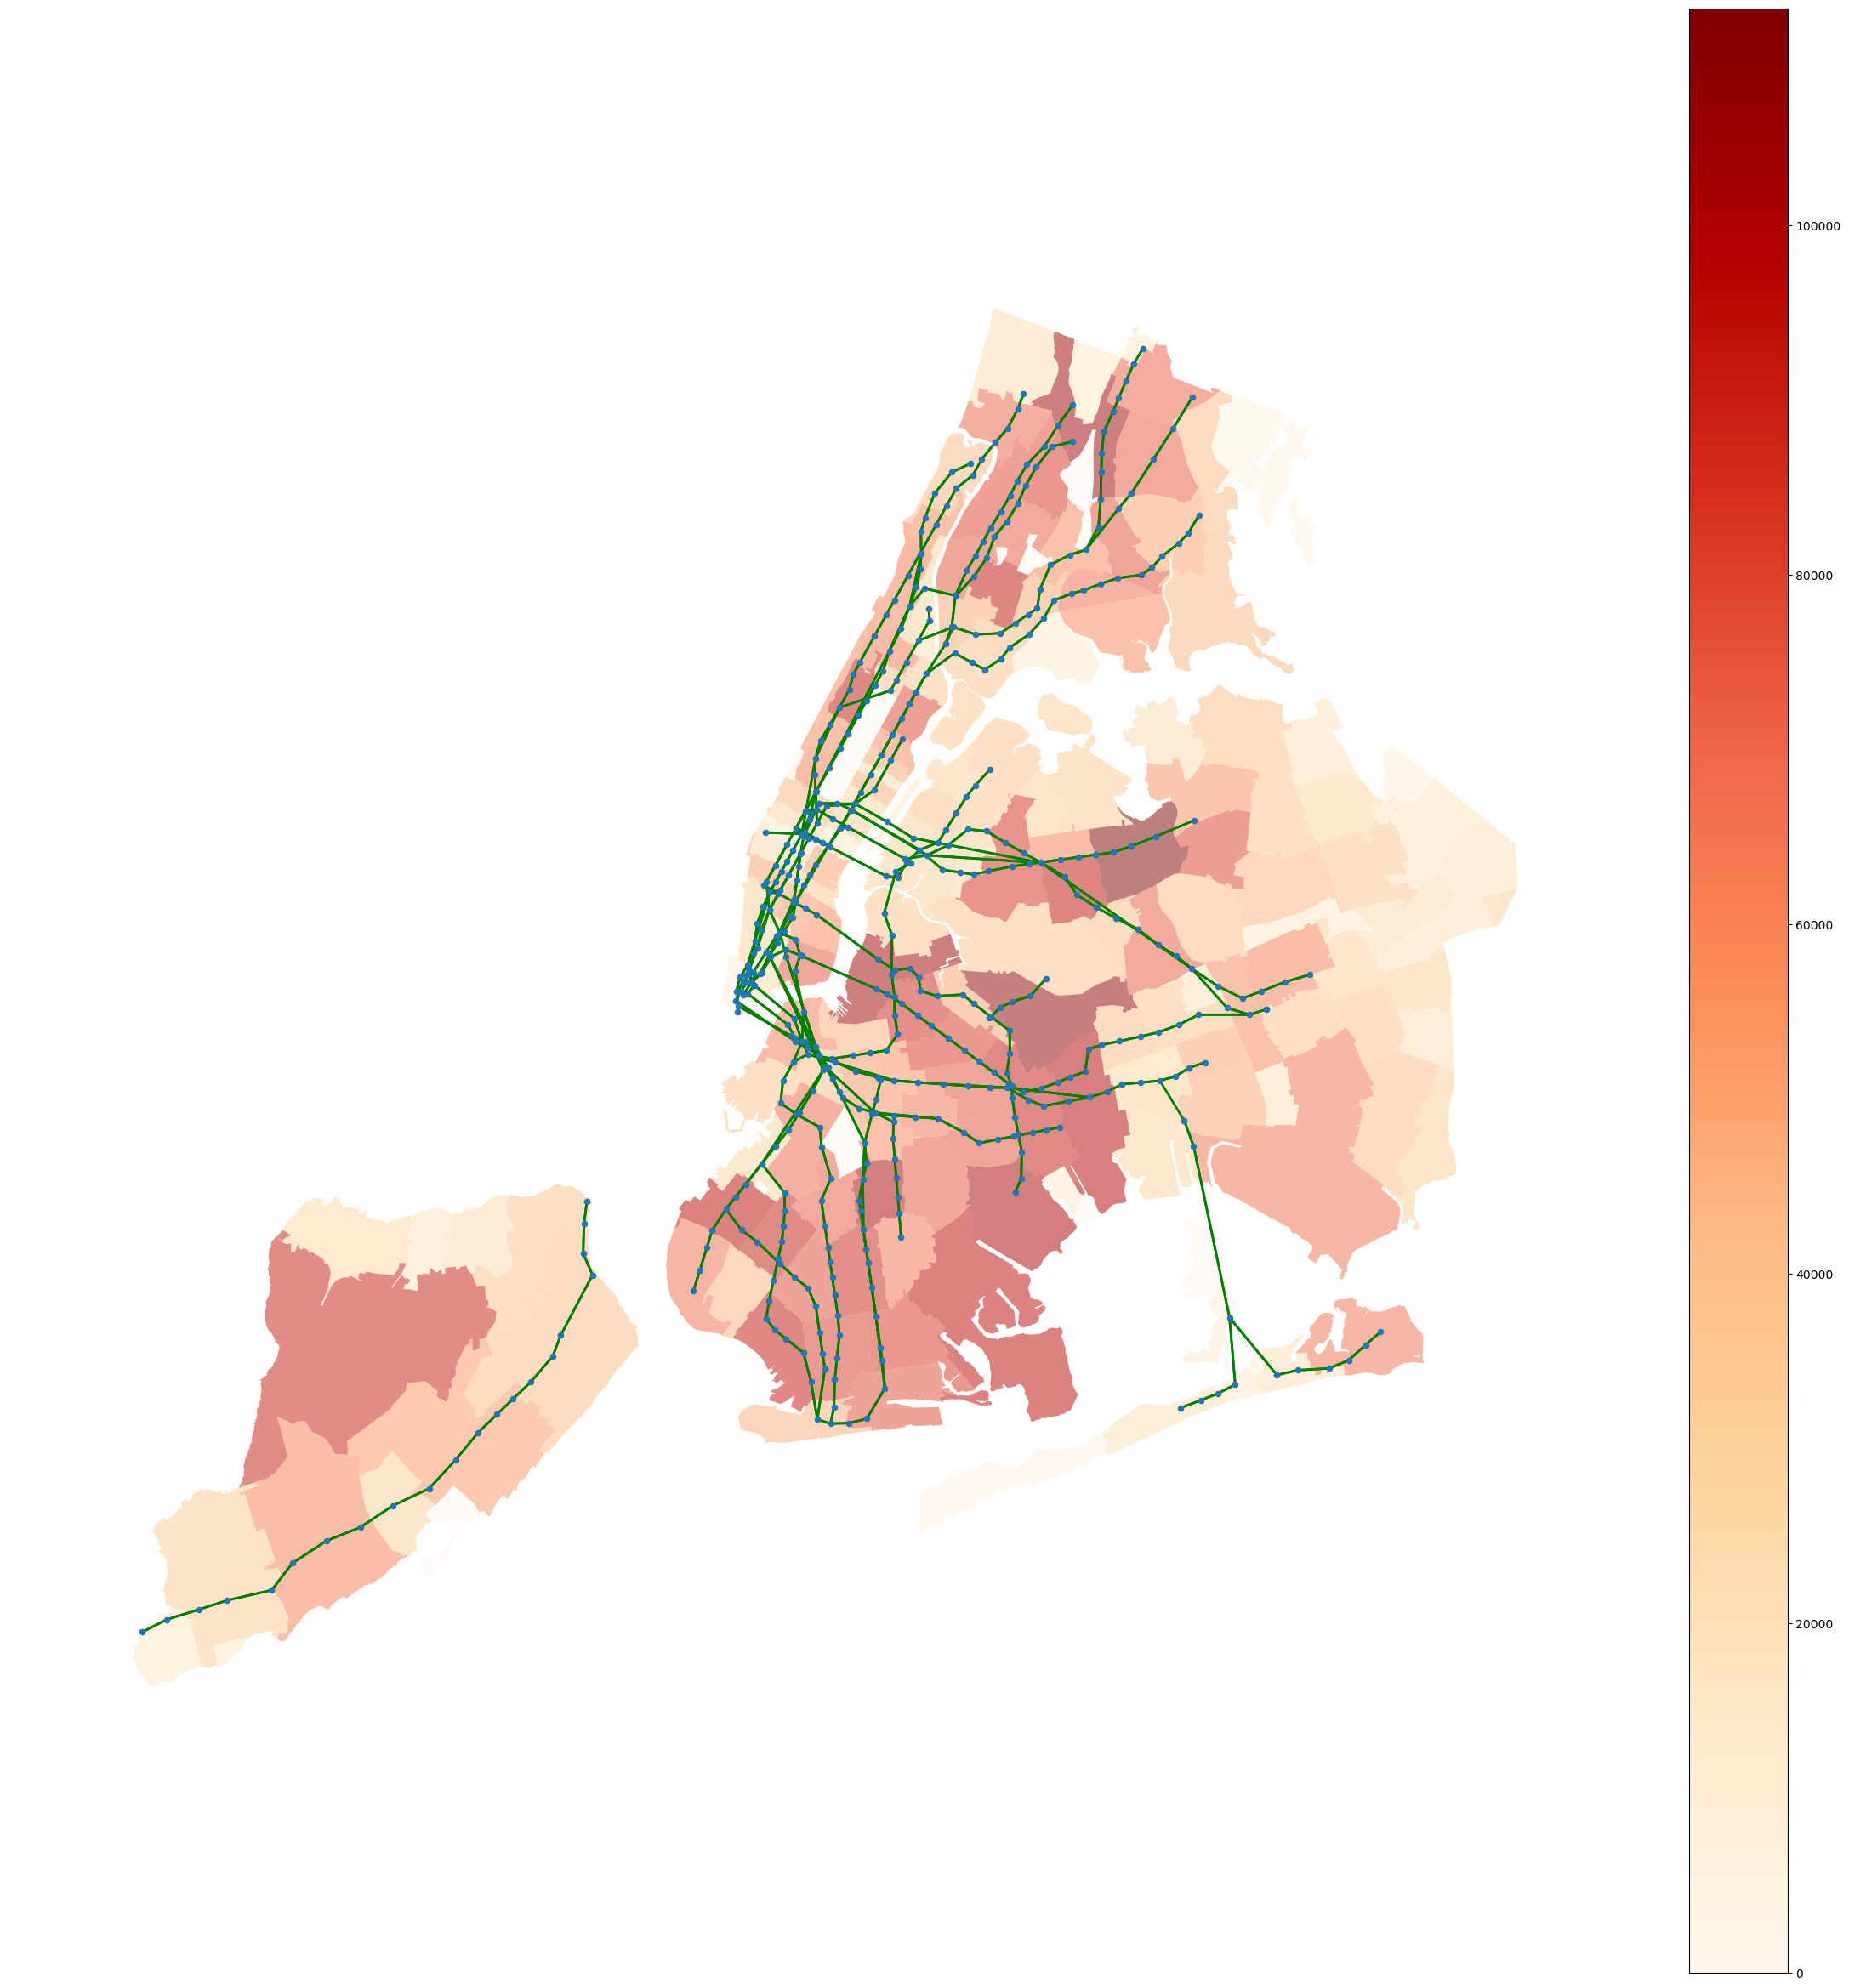

In [8]:
fig, ax = plt.subplots(figsize=(30, 30))
zippop.plot(column='pop_est', legend=True, cmap='OrRd', ax=ax, alpha=0.5)

nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=20,width=2,edge_color='green')

plt.show()


### Find out the centrality of each stations:

In [9]:
#output top tn centrality scores, given the dictionary d
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    result = []
    for i in range(tn):  # Loop to collect top tn nodes
        result.append((ind[i], d[ind[i]]))  # Append the node and its PageRank score as a tuple
    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(result, columns=['Node', 'centrality'])
    return df  # Return the DataFrame


### Find out the degree of each node by the centrlity definition above:

In [10]:
mc1=dict(nx.degree(NYCSubway))
ind1=topdict(mc1,494)
ind1

,Node,centrality
0,R16,14
1,A27,14
2,127,14
3,R31,14
4,G14,12
...,...,...
489,A65,2
490,H01,2
491,301,2
492,726,2


In [11]:
deg = dict(ind1.values)

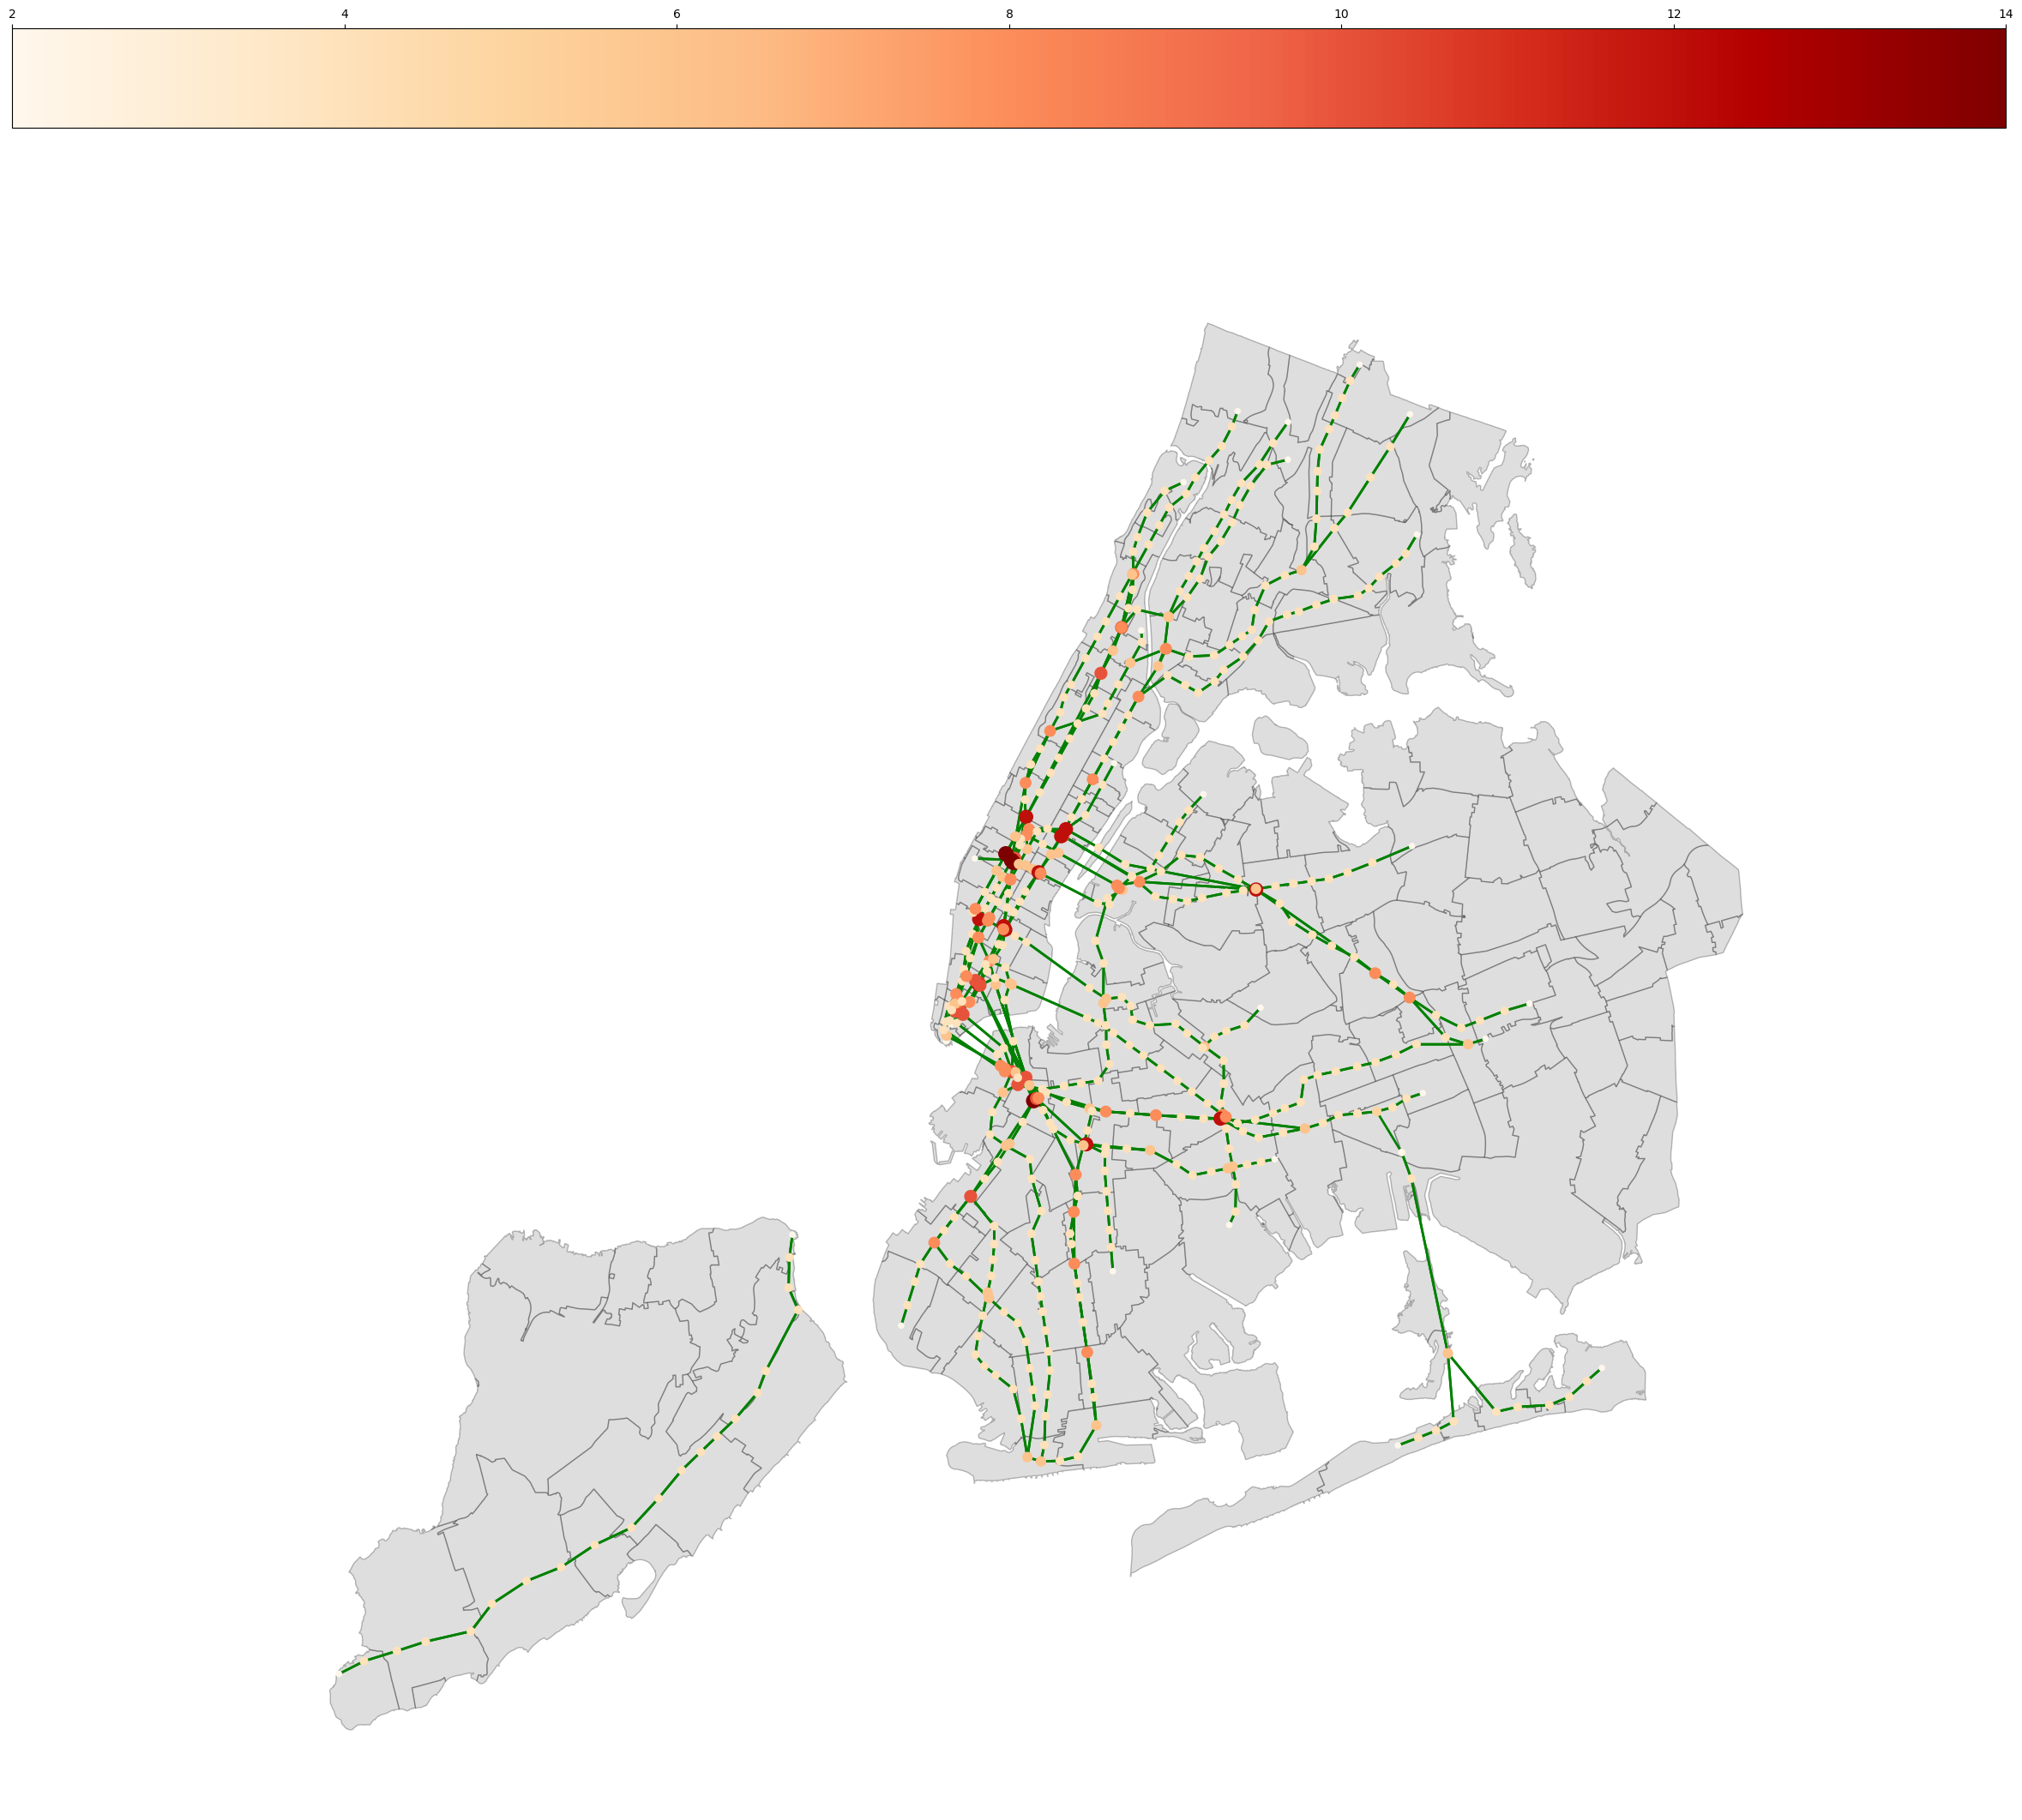

In [12]:
fig, ax = plt.subplots(figsize=(30, 30))

# get rid of color peth of the map, and show the boundarys
zippop.plot(legend=True, ax=ax,color = 'gray',edgecolor='black', alpha=0.26)
# Normalize the color map for nodes, with the maximum value of degree in deep red and minimum in light red.
norm = colors.Normalize(vmin=min(deg.values()), vmax=max(deg.values()))

nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,
        node_size=[deg.get(node, 0) * 10 for node in NYCSubway.nodes()], 
        node_color=[plt.cm.OrRd(norm(deg[node]))for node in NYCSubway.nodes()],
        width=2,edge_color='green')

sm = cm.ScalarMappable(cmap=plt.cm.OrRd, norm=norm)
plt.colorbar(sm, ax=ax,orientation='horizontal', location='top')
plt.show()

In [13]:
import pandas as pd
import geopandas as gpd
import altair as alt
import json

# Since these data are each more than 5,000 rows we'll import from the URLs
airports = data.airports.url
flights_airport = data.flights_airport.url

states = alt.topo_feature(data.us_10m.url, feature="states")

# Create mouseover selection
select_city = alt.selection_single(
    on="mouseover", nearest=True, fields=["origin"], empty="none"
)

# Define which attributes to lookup from airports.csv
lookup_data = alt.LookupData(
    airports, key="iata", fields=["state", "latitude", "longitude"]
)

background = alt.Chart(states).mark_geoshape(
    fill="lightgray",
    stroke="white"
).properties(
    width=750,
    height=500
).project("albersUsa")

connections = alt.Chart(flights_airport).mark_rule(opacity=0.35).encode(
    latitude="latitude:Q",
    longitude="longitude:Q",
    latitude2="lat2:Q",
    longitude2="lon2:Q"
).transform_lookup(
    lookup="origin",
    from_=lookup_data
).transform_lookup(
    lookup="destination",
    from_=lookup_data,
    as_=["state", "lat2", "lon2"]
).transform_filter(
    select_city
)

points = alt.Chart(flights_airport).mark_circle().encode(
    latitude="latitude:Q",
    longitude="longitude:Q",
    size=alt.Size("routes:Q", scale=alt.Scale(range=[0, 1000]), legend=None),
    order=alt.Order("routes:Q", sort="descending"),
    tooltip=["origin:N", "routes:Q"]
).transform_aggregate(
    routes="count()",
    groupby=["origin"]
).transform_lookup(
    lookup="origin",
    from_=lookup_data
).transform_filter(
    (alt.datum.state != "PR") & (alt.datum.state != "VI")
).add_selection(
    select_city
)

(background + connections + points).configure_view(stroke=None)

NameError: name 'data' is not defined

### Find out the Betweenness of each node by the centrlity definition above:

In [ ]:
mc2=dict(nx.betweenness_centrality(NYCSubway))
ind2=topdict(mc2,494)
ind2

In [ ]:
btw = dict(ind2.values)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))

# get rid of color peth of the map, and show the boundarys
zippop.plot(legend=True, ax=ax,color = 'gray',edgecolor='black', alpha=0.26)
# Normalize the color map for nodes, with the maximum value of degree in deep red and minimum in light red.
norm = colors.Normalize(vmin=min(btw.values()), vmax=max(btw.values()))

nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,
        node_size=[btw.get(node, 0) * 1000 for node in NYCSubway.nodes()], 
        node_color=[plt.cm.OrRd(norm(btw[node]))for node in NYCSubway.nodes()],
        width=2,edge_color='green')

sm = cm.ScalarMappable(cmap=plt.cm.OrRd, norm=norm)
plt.colorbar(sm, ax=ax,orientation='horizontal', location='top')
plt.show()

### Find out the Closeness of each node by the centrlity definition above:

In [ ]:
mc3=dict(nx.closeness_centrality(NYCSubway))
ind3=topdict(mc3,494)
cls = dict(ind3.values)

In [ ]:
ind3

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))

# get rid of color peth of the map, and show the boundarys
zippop.plot(legend=True, ax=ax,color = 'gray',edgecolor='black', alpha=0.26)
# Normalize the color map for nodes, with the maximum value of degree in deep red and minimum in light red.
norm = colors.Normalize(vmin=min(cls.values()), vmax=max(cls.values()))

nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,
        node_size=[cls.get(node, 0) * 800 for node in NYCSubway.nodes()], 
        node_color=[plt.cm.OrRd(norm(cls[node]))for node in NYCSubway.nodes()],
        width=2,edge_color='green')

sm = cm.ScalarMappable(cmap=plt.cm.OrRd, norm=norm)
plt.colorbar(sm, ax=ax,orientation='horizontal', location='top')
plt.show()